In [ ]:
pip install ultralytics pyyaml torch opencv-python


In [ ]:
 pip install -U albumentations


In [20]:
import os
import shutil

# Define the working directory
WORKING_DIR = "/kaggle/working/"

# Function to clear the working directory
def clear_working_directory(directory):
    try:
        if os.path.exists(directory):
            for item in os.listdir(directory):
                item_path = os.path.join(directory, item)
                try:
                    if os.path.isfile(item_path) or os.path.islink(item_path):
                        os.unlink(item_path)  # Remove files or symlinks
                    elif os.path.isdir(item_path):
                        shutil.rmtree(item_path)  # Remove directories
                    print(f"Removed: {item_path}")
                except Exception as e:
                    print(f"Error removing {item_path}: {e}")
            print(f"Successfully cleared {directory}")
        else:
            print(f"Directory {directory} does not exist")
    except Exception as e:
        print(f"Error clearing {directory}: {e}")

# Clear the working directory
print("Clearing /kaggle/working/ directory...")
clear_working_directory(WORKING_DIR)

Clearing /kaggle/working/ directory...
Removed: /kaggle/working/data.yaml
Removed: /kaggle/working/class_imbalance_summary.txt
Removed: /kaggle/working/augmented_samples.png
Removed: /kaggle/working/augmented_train
Successfully cleared /kaggle/working/


Starting preprocessing...


Loading images from /kaggle/input/dental-1/train/images: 100%|██████████| 4488/4488 [00:47<00:00, 94.41it/s]


Loaded 4488 training images
Initial class distribution: cavity=6384, pa=1950


Augmenting images: 100%|██████████| 90/90 [02:30<00:00,  1.67s/it]


Visualizing sample augmented images...


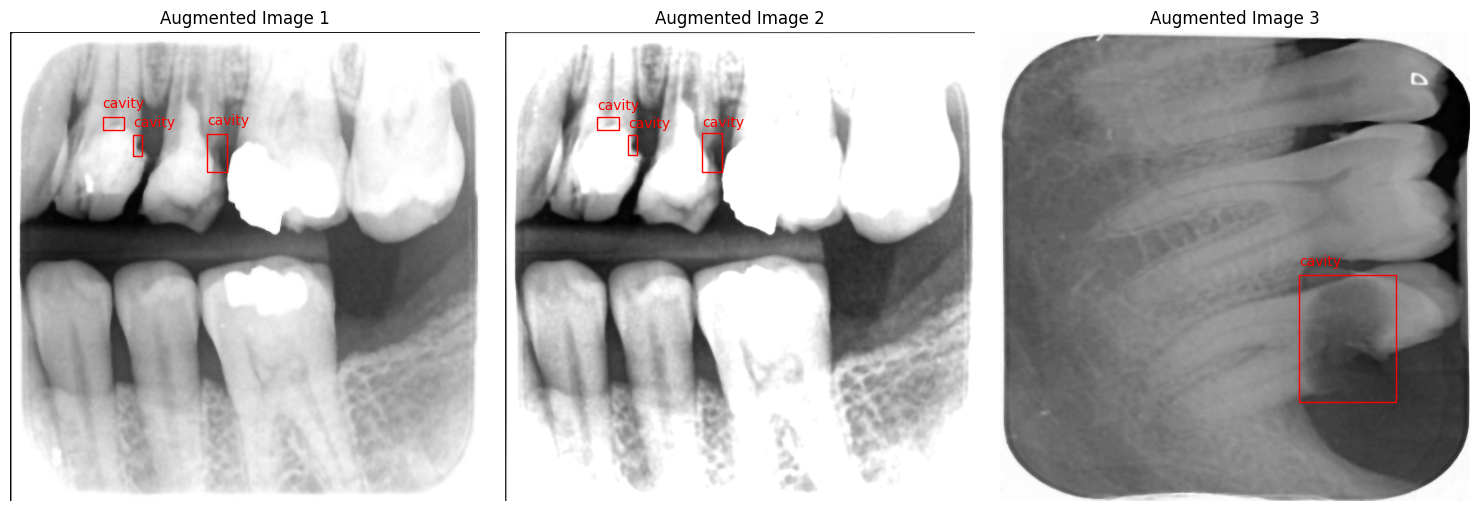

Instances after augmentation: cavity=18329, pa=9722
Balanced dataset size: 9979 images
Final class distribution: cavity=13713, pa=9375
Final imbalance ratio: 1.46


Saving augmented data: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Saved 9979 images and 9979 labels to /kaggle/working/augmented_train/images
Preprocessing completed: Balanced dataset saved to /kaggle/working/augmented_train/images


In [21]:
import os
import cv2
import numpy as np
import albumentations as A
from pathlib import Path
import yaml
import warnings
import random
import matplotlib.pyplot as plt
import logging
from collections import defaultdict
from itertools import islice
from tqdm import tqdm

# Set up logging
log_file = "/kaggle/working/preprocessing_log.txt"
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define paths for Kaggle dataset
DATA_YAML = "/kaggle/input/dental-1/data.yaml"
TRAIN_IMAGES_DIR = "/kaggle/input/dental-1/train/images"
TRAIN_LABELS_DIR = "/kaggle/input/dental-1/train/labels"
VAL_IMAGES_DIR = "/kaggle/input/dental-1/valid/images"
TEST_IMAGES_DIR = "/kaggle/input/dental-1/test/images"
OUTPUT_IMAGES_DIR = "/kaggle/working/augmented_train/images"
OUTPUT_LABELS_DIR = "/kaggle/working/augmented_train/labels"

# Start preprocessing
print("Starting preprocessing...")
logger.info("Starting preprocessing")

# Verify data.yaml exists
if not os.path.exists(DATA_YAML):
    error_msg = f"data.yaml not found at {DATA_YAML}"
    logger.error(error_msg)
    raise FileNotFoundError(error_msg)

# Load data.yaml
try:
    with open(DATA_YAML, 'r') as f:
        data_config = yaml.safe_load(f)
    logger.info("data.yaml loaded successfully")
except Exception as e:
    error_msg = f"Failed to load data.yaml: {e}"
    logger.error(error_msg)
    raise RuntimeError(error_msg)

# Override paths in data.yaml
data_config['train'] = "../train/images"
data_config['val'] = "../valid/images"
data_config['test'] = "../test/images"
class_names = data_config.get('names', ['cavity', 'pa'])
num_classes = data_config.get('nc', 2)
logger.info(f"Classes: {class_names}, Number of classes: {num_classes}")

# Verify directories exist
for directory in [TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR]:
    if not os.path.exists(directory):
        error_msg = f"Directory not found: {directory}"
        logger.error(error_msg)
        raise FileNotFoundError(error_msg)
logger.info("All input directories verified")

# Define augmentation pipelines with configurable parameters
def create_augmentation_pipeline(is_pa_class=True, image_size=640):
    """Create an augmentation pipeline tailored for dental X-rays."""
    params = {
        'rotate_limit': 15 if is_pa_class else 10,
        'brightness_limit': 0.4 if is_pa_class else 0.2,
        'contrast_limit': 0.4 if is_pa_class else 0.2,
        'gauss_noise_var_limit': (5.0, 30.0) if is_pa_class else (5.0, 20.0),
        'gauss_noise_p': 0.3 if is_pa_class else 0.2,
        'clahe_clip_limit': 3.0 if is_pa_class else 2.5,
        'clahe_p': 1.0 if is_pa_class else 0.8,
        'horizontal_flip_p': 0.5 if is_pa_class else 0.3,
        'vertical_flip_p': 0.5 if is_pa_class else 0.3,
        'shift_limit': 0.1 if is_pa_class else 0.05,
        'scale_limit': 0.1 if is_pa_class else 0.05,
        'sharpen_alpha': (0.1, 0.3) if is_pa_class else (0.1, 0.2),
        'sharpen_p': 0.5 if is_pa_class else 0.3
    }
    return A.Compose([
        A.Rotate(limit=params['rotate_limit'], p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=params['brightness_limit'],
            contrast_limit=params['contrast_limit'],
            p=0.5
        ),
        A.GaussNoise(var_limit=params['gauss_noise_var_limit'], p=params['gauss_noise_p']),
        A.CLAHE(
            clip_limit=params['clahe_clip_limit'],
            tile_grid_size=(8, 8),
            p=params['clahe_p']
        ),
        A.HorizontalFlip(p=params['horizontal_flip_p']),
        A.VerticalFlip(p=params['vertical_flip_p']),
        A.ShiftScaleRotate(
            shift_limit=params['shift_limit'],
            scale_limit=params['scale_limit'],
            rotate_limit=params['rotate_limit'],
            p=0.5
        ),
        A.Sharpen(alpha=params['sharpen_alpha'], p=params['sharpen_p']),
        A.GaussianBlur(blur_limit=(3, 3), p=0.1),
        A.Equalize(p=0.3),
        A.Resize(height=image_size, width=image_size, p=1.0)
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.4
    ))

# Initialize augmentation pipelines
pa_augmentation = create_augmentation_pipeline(is_pa_class=True)
cavity_augmentation = create_augmentation_pipeline(is_pa_class=False)
logger.info("Augmentation pipelines initialized")

# Function to preprocess a single image
def preprocess_image(image):
    """Apply preprocessing steps to enhance image quality while preserving details."""
    image = cv2.medianBlur(image, ksize=3)  # Reduce noise
    image = cv2.bilateralFilter(image, d=5, sigmaColor=30, sigmaSpace=30)  # Preserve edges
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # Normalize intensity
    return image

# Function to check image contrast
def check_contrast(image, min_std=15):
    """Check if the image has sufficient contrast based on standard deviation."""
    if image.size == 0:
        logger.warning("Image is empty during contrast check")
        return False
    std = np.std(image)
    is_acceptable = std >= min_std
    logger.debug(f"Image contrast std: {std:.2f}, Acceptable: {is_acceptable}")
    return is_acceptable

# Function to convert grayscale to 3-channel for augmentation
def to_3channel_grayscale(image):
    """Convert grayscale image to 3-channel for augmentation compatibility."""
    if len(image.shape) == 2:
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

# Function to convert back to single-channel grayscale
def to_single_channel(image):
    """Convert 3-channel image back to single-channel grayscale."""
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

# Function to validate bounding box coordinates
def validate_bbox(bbox, img_width=1.0, img_height=1.0):
    """Validate that bounding box coordinates are within bounds."""
    x_center, y_center, width, height = bbox
    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
        return False
    return True

# Function to load images and labels
def load_data(image_dir, label_dir):
    """Load images and their corresponding labels from directories."""
    images, bboxes_list, labels_list = [], [], []
    image_files = list(Path(image_dir).glob("*.jpg"))
    if not image_files:
        logger.warning(f"No images found in {image_dir}")
        return images, bboxes_list, labels_list

    for img_file in tqdm(image_files, desc=f"Loading images from {image_dir}"):
        img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        if img is None:
            logger.warning(f"Failed to load image {img_file}")
            continue
        if len(img.shape) != 2:
            logger.warning(f"Image {img_file} is not grayscale (shape: {img.shape})")
            continue
        img = preprocess_image(img)
        label_file = Path(label_dir) / (img_file.stem + ".txt")
        if not label_file.exists():
            logger.warning(f"Label file missing for {img_file}")
            images.append(img)
            bboxes_list.append([])
            labels_list.append([])
            continue
        with open(label_file, 'r') as f:
            lines = f.readlines()
        img_bboxes, img_labels = [], []
        for line in lines:
            try:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                if cls not in [0, 1]:
                    logger.warning(f"Invalid class {cls} in {label_file}")
                    continue
                bbox = [x_center, y_center, width, height]
                if not validate_bbox(bbox):
                    logger.warning(f"Invalid bbox coordinates in {label_file}: {bbox}")
                    continue
                img_bboxes.append(bbox)
                img_labels.append(int(cls))
            except ValueError as e:
                logger.warning(f"Invalid label format in {label_file}: {e}")
                continue
        images.append(img)
        bboxes_list.append(img_bboxes)
        labels_list.append(img_labels)
    logger.info(f"Loaded {len(images)} images from {image_dir}")
    return images, bboxes_list, labels_list

# Function to visualize augmented images
def visualize_augmented(images, bboxes_list, labels_list, class_names, num_samples=3):
    """Visualize a sample of augmented images with bounding boxes."""
    if not images:
        logger.warning("No images available for visualization")
        return
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = images[i]
        if len(img.shape) == 3:
            img = to_single_channel(img)
        if img.shape[0] == 0 or img.shape[1] == 0:
            logger.warning(f"Invalid image dimensions for visualization at index {i}")
            continue
        plt.imshow(img, cmap='gray')
        h, w = img.shape
        for bbox, cls in zip(bboxes_list[i], labels_list[i]):
            x_center, y_center, width, height = bbox
            x_pixel = (x_center - width / 2) * w
            y_pixel = (y_center - height / 2) * h
            w_pixel = width * w
            h_pixel = height * h
            rect = plt.Rectangle(
                (x_pixel, y_pixel),
                w_pixel,
                h_pixel,
                edgecolor='r' if cls == 0 else 'b',
                facecolor='none'
            )
            plt.gca().add_patch(rect)
            plt.text(
                x_pixel,
                y_pixel - 10,
                class_names[cls],
                color='r' if cls == 0 else 'b',
                fontsize=10
            )
        plt.title(f"Augmented Image {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("/kaggle/working/augmented_samples.png")
    plt.show()
    logger.info(f"Visualized {num_samples} augmented images, saved to /kaggle/working/augmented_samples.png")

# Load training data
train_images, train_bboxes, train_labels = load_data(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR)
if not train_images:
    error_msg = "No valid training images loaded"
    logger.error(error_msg)
    raise ValueError(error_msg)
print(f"Loaded {len(train_images)} training images")
logger.info(f"Loaded {len(train_images)} training images")

# Calculate initial class distribution
initial_cavity_instances = sum([lbls.count(0) for lbls in train_labels])
initial_pa_instances = sum([lbls.count(1) for lbls in train_labels])
print(f"Initial class distribution: cavity={initial_cavity_instances}, pa={initial_pa_instances}")
logger.info(f"Initial class distribution: cavity={initial_cavity_instances}, pa={initial_pa_instances}")

# Target instances per class for 1:1 ratio
target_instances_per_class = 7000

# Calculate augmentation needs
pa_image_count = sum(1 for lbls in train_labels if 1 in lbls)
cavity_image_count = sum(1 for lbls in train_labels if 0 in lbls)
augmentations_per_pa = max(1, int((target_instances_per_class - initial_pa_instances) / pa_image_count) + 1) if pa_image_count > 0 else 1
augmentations_per_cavity = max(1, int((target_instances_per_class - initial_cavity_instances) / cavity_image_count) + 1) if cavity_image_count > 0 else 1
logger.info(f"Applying {augmentations_per_pa} augmentations per PA image, {augmentations_per_cavity} augmentations per cavity image")

# Augment data in batches
augmented_images, augmented_bboxes, augmented_labels = [], [], []
batch_size = 50
for batch_start in tqdm(range(0, len(train_images), batch_size), desc="Augmenting images"):
    batch_images = train_images[batch_start:batch_start + batch_size]
    batch_bboxes = train_bboxes[batch_start:batch_start + batch_size]
    batch_labels = train_labels[batch_start:batch_start + batch_size]
    
    for img, bboxes, lbls in zip(batch_images, batch_bboxes, batch_labels):
        img_3ch = to_3channel_grayscale(img)
        has_pa, has_cavity = 1 in lbls, 0 in lbls
        num_augmentations = augmentations_per_pa if has_pa else (augmentations_per_cavity if has_cavity else 1)
        aug_pipeline = pa_augmentation if has_pa else (cavity_augmentation if has_cavity else None)
        
        # Add original image
        if bboxes:
            augmented_images.append(img)
            augmented_bboxes.append(bboxes)
            augmented_labels.append(lbls)
        
        # Apply augmentations
        if aug_pipeline and bboxes:
            for _ in range(num_augmentations):
                aug = aug_pipeline(image=img_3ch, bboxes=bboxes, class_labels=lbls)
                if aug['bboxes']:
                    aug_img = to_single_channel(aug['image'])
                    if check_contrast(aug_img):
                        valid_bboxes = [bbox for bbox in aug['bboxes'] if validate_bbox(bbox)]
                        valid_labels = [lbl for bbox, lbl in zip(aug['bboxes'], aug['class_labels']) if validate_bbox(bbox)]
                        if valid_bboxes:
                            augmented_images.append(aug_img)
                            augmented_bboxes.append(valid_bboxes)
                            augmented_labels.append([int(cls) for cls in valid_labels])
        else:
            augmented_images.append(img)
            augmented_bboxes.append(bboxes)
            augmented_labels.append(lbls)

# Visualize augmented images
print("Visualizing sample augmented images...")
visualize_augmented(augmented_images, augmented_bboxes, augmented_labels, class_names, num_samples=3)

# Recalculate instances after augmentation
post_augmentation_cavity_instances = sum([lbls.count(0) for lbls in augmented_labels])
post_augmentation_pa_instances = sum([lbls.count(1) for lbls in augmented_labels])
print(f"Instances after augmentation: cavity={post_augmentation_cavity_instances}, pa={post_augmentation_pa_instances}")
logger.info(f"Instances after augmentation: cavity={post_augmentation_cavity_instances}, pa={post_augmentation_pa_instances}")

# Trim both classes to target_instances_per_class for 1:1 ratio
final_images, final_bboxes, final_labels = [], [], []
cavity_count, pa_count = 0, 0

# Group images by class for balanced sampling
pa_images = [(img, bboxes, lbls) for img, bboxes, lbls in zip(augmented_images, augmented_bboxes, augmented_labels) if 1 in lbls]
cavity_images = [(img, bboxes, lbls) for img, bboxes, lbls in zip(augmented_images, augmented_bboxes, augmented_labels) if 0 in lbls]
background_images = [(img, bboxes, lbls) for img, bboxes, lbls in zip(augmented_images, augmented_bboxes, augmented_labels) if not bboxes]

# Shuffle for randomness
random.shuffle(pa_images)
random.shuffle(cavity_images)

# Select PA images
for img, bboxes, lbls in pa_images:
    pa_in_image = lbls.count(1)
    if pa_count + pa_in_image <= target_instances_per_class:
        final_images.append(img)
        final_bboxes.append(bboxes)
        final_labels.append(lbls)
        pa_count += pa_in_image
    else:
        remaining = target_instances_per_class - pa_count
        if remaining > 0:
            new_bboxes, new_labels = [], []
            pa_added = 0
            for bbox, lbl in zip(bboxes, lbls):
                if lbl == 1 and pa_added < remaining:
                    new_bboxes.append(bbox)
                    new_labels.append(lbl)
                    pa_added += 1
                elif lbl == 0:
                    new_bboxes.append(bbox)
                    new_labels.append(lbl)
            if new_bboxes:
                final_images.append(img)
                final_bboxes.append(new_bboxes)
                final_labels.append(new_labels)
                pa_count += pa_added
        break

# Select cavity images
for img, bboxes, lbls in cavity_images:
    cavity_in_image = lbls.count(0)
    if cavity_count + cavity_in_image <= target_instances_per_class:
        final_images.append(img)
        final_bboxes.append(bboxes)
        final_labels.append(lbls)
        cavity_count += cavity_in_image
    else:
        remaining = target_instances_per_class - cavity_count
        if remaining > 0:
            new_bboxes, new_labels = [], []
            cavity_added = 0
            for bbox, lbl in zip(bboxes, lbls):
                if lbl == 0 and cavity_added < remaining:
                    new_bboxes.append(bbox)
                    new_labels.append(lbl)
                    cavity_added += 1
                elif lbl == 1:
                    new_bboxes.append(bbox)
                    new_labels.append(lbl)
            if new_bboxes:
                final_images.append(img)
                final_bboxes.append(new_bboxes)
                final_labels.append(new_labels)
                cavity_count += cavity_added
        break

# Add background images
final_images.extend([img for img, _, _ in background_images])
final_bboxes.extend([bboxes for _, bboxes, _ in background_images])
final_labels.extend([lbls for _, _, lbls in background_images])

# Verify final dataset
final_cavity_instances = sum([lbls.count(0) for lbls in final_labels])
final_pa_instances = sum([lbls.count(1) for lbls in final_labels])
if final_pa_instances == 0 or final_cavity_instances == 0:
    error_msg = "No instances of one or both classes in final dataset"
    logger.error(error_msg)
    raise ValueError(error_msg)
imbalance_ratio = final_cavity_instances / final_pa_instances if final_pa_instances > 0 else float('inf')
print(f"Balanced dataset size: {len(final_images)} images")
print(f"Final class distribution: cavity={final_cavity_instances}, pa={final_pa_instances}")
print(f"Final imbalance ratio: {imbalance_ratio:.2f}")
logger.info(f"Balanced dataset size: {len(final_images)} images")
logger.info(f"Final class distribution: cavity={final_cavity_instances}, pa={final_pa_instances}")
logger.info(f"Final imbalance ratio: {imbalance_ratio:.2f}")

# Save class imbalance summary
summary_path = "/kaggle/working/class_imbalance_summary.txt"
try:
    total_instances = final_cavity_instances + final_pa_instances
    with open(summary_path, 'w') as f:
        f.write("Class Distribution After Augmentation:\n")
        f.write(f"Cavity (Class 0): {final_cavity_instances} instances ({final_cavity_instances / total_instances * 100:.2f}%)\n")
        f.write(f"PA (Class 1): {final_pa_instances} instances ({final_pa_instances / total_instances * 100:.2f}%)\n")
        f.write(f"Imbalance Ratio (Cavity/PA): {imbalance_ratio:.2f}\n")
        f.write(f"Total Instances: {total_instances}\n")
    logger.info(f"Class imbalance summary saved to {summary_path}")
except Exception as e:
    error_msg = f"Failed to save class imbalance summary: {e}"
    logger.error(error_msg)
    raise RuntimeError(error_msg)

# Save augmented data to disk in batches
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

save_batch_size = 100
for batch_start in tqdm(range(0, len(final_images), save_batch_size), desc="Saving augmented data"):
    batch = list(zip(
        final_images[batch_start:batch_start + save_batch_size],
        final_bboxes[batch_start:batch_start + save_batch_size],
        final_labels[batch_start:batch_start + save_batch_size]
    ))
    for i, (img, bboxes, lbls) in enumerate(batch, start=batch_start):
        img_path = f"{OUTPUT_IMAGES_DIR}/aug_{i}.jpg"
        label_path = f"{OUTPUT_LABELS_DIR}/aug_{i}.txt"
        if len(img.shape) == 3:
            img = to_single_channel(img)
        if len(img.shape) != 2:
            logger.warning(f"Saved image {img_path} is not single-channel grayscale (shape: {img.shape})")
            continue
        if not cv2.imwrite(img_path, img):
            logger.error(f"Failed to save image {img_path}")
            continue
        try:
            with open(label_path, 'w') as f:
                for cls, (x, y, w, h) in zip(lbls, bboxes):
                    f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        except Exception as e:
            logger.error(f"Failed to save label {label_path}: {e}")
            continue

# Verify saved files
saved_images = len(list(Path(OUTPUT_IMAGES_DIR).glob("*.jpg")))
saved_labels = len(list(Path(OUTPUT_LABELS_DIR).glob("*.txt")))
if saved_images != saved_labels:
    logger.warning(f"Mismatch: Saved {saved_images} images but {saved_labels} labels")
print(f"Saved {saved_images} images and {saved_labels} labels to {OUTPUT_IMAGES_DIR}")
logger.info(f"Saved {saved_images} images and {saved_labels} labels to {OUTPUT_IMAGES_DIR}")

# Update data.yaml for augmented dataset
data_config['train'] = OUTPUT_IMAGES_DIR
try:
    with open("/kaggle/working/data.yaml", 'w') as f:
        yaml.safe_dump(data_config, f)
    logger.info("data.yaml updated successfully")
except Exception as e:
    error_msg = f"Failed to update data.yaml: {e}"
    logger.error(error_msg)
    raise RuntimeError(error_msg)

print(f"Preprocessing completed: Balanced dataset saved to {OUTPUT_IMAGES_DIR}")
logger.info(f"Preprocessing completed: Balanced dataset saved to {OUTPUT_IMAGES_DIR}")

In [22]:
import os
from pathlib import Path

# Define paths
AUGMENTED_LABEL_DIR = "/kaggle/working/augmented_train/labels"
OUTPUT_SUMMARY = "/kaggle/working/class_imbalance_summary.txt"

# Initialize counters
cavity_count = 0
pa_count = 0

# Check if label directory exists
if not os.path.exists(AUGMENTED_LABEL_DIR):
    raise FileNotFoundError(f"Augmented label directory not found at {AUGMENTED_LABEL_DIR}")

# Read all label files
label_files = list(Path(AUGMENTED_LABEL_DIR).glob("*.txt"))
if not label_files:
    raise FileNotFoundError(f"No label files found in {AUGMENTED_LABEL_DIR}")

for label_file in label_files:
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            try:
                cls = int(float(line.strip().split()[0]))  # Class ID is first value
                if cls == 0:
                    cavity_count += 1
                elif cls == 1:
                    pa_count += 1
                else:
                    print(f"Warning: Invalid class {cls} in {label_file}")
            except (ValueError, IndexError):
                print(f"Warning: Invalid label format in {label_file}")
    except Exception as e:
        print(f"Error reading {label_file}: {e}")

# Calculate total instances and percentages
total_instances = cavity_count + pa_count
if total_instances == 0:
    raise ValueError("No valid class instances found in label files")

cavity_percent = (cavity_count / total_instances) * 100
pa_percent = (pa_count / total_instances) * 100
imbalance_ratio = cavity_count / pa_count if pa_count > 0 else float('inf')

# Print results
print(f"\nClass Distribution After Augmentation:")
print(f"Cavity (Class 0): {cavity_count} instances ({cavity_percent:.2f}%)")
print(f"PA (Class 1): {pa_count} instances ({pa_percent:.2f}%)")
print(f"Imbalance Ratio (Cavity/PA): {imbalance_ratio:.2f}")
print(f"Total Instances: {total_instances}")

# Save summary to file
summary = (
    "Class Distribution After Augmentation:\n"
    f"Cavity (Class 0): {cavity_count} instances ({cavity_percent:.2f}%)\n"
    f"PA (Class 1): {pa_count} instances ({pa_percent:.2f}%)\n"
    f"Imbalance Ratio (Cavity/PA): {imbalance_ratio:.2f}\n"
    f"Total Instances: {total_instances}\n"
)
with open(OUTPUT_SUMMARY, 'w') as f:
    f.write(summary)

print(f"Summary saved to {OUTPUT_SUMMARY}")


Class Distribution After Augmentation:
Cavity (Class 0): 13713 instances (59.39%)
PA (Class 1): 9375 instances (40.61%)
Imbalance Ratio (Cavity/PA): 1.46
Total Instances: 23088
Summary saved to /kaggle/working/class_imbalance_summary.txt


Checking Class Imbalance

In [23]:
import os
import random
import shutil
from pathlib import Path
import zipfile

# Define paths
AUGMENTED_DIR = "/kaggle/working/augmented_train"
OUTPUT_DIR = "/kaggle/working/random_augmented_images"
ZIP_FILE = "/kaggle/working/random_augmented_images.zip"
NUM_IMAGES = 10  # Number of random images to download

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Get list of augmented images
image_dir = os.path.join(AUGMENTED_DIR, "images")
image_files = list(Path(image_dir).glob("*.jpg"))

if not image_files:
    raise FileNotFoundError(f"No images found in {image_dir}")

# Randomly select images
selected_images = random.sample(image_files, min(NUM_IMAGES, len(image_files)))

# Copy selected images and their labels
for img_file in selected_images:
    # Copy image
    shutil.copy(img_file, os.path.join(OUTPUT_DIR, img_file.name))
    
    # Copy corresponding label file
    label_file = os.path.join(AUGMENTED_DIR, "labels", img_file.stem + ".txt")
    if os.path.exists(label_file):
        shutil.copy(label_file, os.path.join(OUTPUT_DIR, img_file.stem + ".txt"))
    else:
        print(f"Warning: Label file missing for {img_file.name}")

# Create zip file
with zipfile.ZipFile(ZIP_FILE, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(OUTPUT_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, OUTPUT_DIR)
            zipf.write(file_path, arcname)

print(f"Selected {len(selected_images)} images and their labels.")
print(f"Zip file created at {ZIP_FILE}")
print("You can download the zip file from the Kaggle output panel.")

Selected 10 images and their labels.
Zip file created at /kaggle/working/random_augmented_images.zip
You can download the zip file from the Kaggle output panel.


In [8]:
import os
import cv2
import numpy as np
from pathlib import Path
import yaml
import warnings
import logging
from tqdm import tqdm

# Set up logging
log_file = "/kaggle/working/preprocessing_valid_test_log.txt"
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Define paths for Kaggle dataset
DATA_YAML = "/kaggle/input/dental-1/data.yaml"
VAL_IMAGES_DIR = "/kaggle/input/dental-1/valid/images"
VAL_LABELS_DIR = "/kaggle/input/dental-1/valid/labels"
TEST_IMAGES_DIR = "/kaggle/input/dental-1/test/images"
TEST_LABELS_DIR = "/kaggle/input/dental-1/test/labels"
OUTPUT_VAL_IMAGES_DIR = "/kaggle/working/preprocessed_valid/images"
OUTPUT_VAL_LABELS_DIR = "/kaggle/working/preprocessed_valid/labels"
OUTPUT_TEST_IMAGES_DIR = "/kaggle/working/preprocessed_test/images"
OUTPUT_TEST_LABELS_DIR = "/kaggle/working/preprocessed_test/labels"

# Start preprocessing
print("Starting preprocessing for validation and test sets...")
logger.info("Starting preprocessing for validation and test sets")

# Verify data.yaml exists
if not os.path.exists(DATA_YAML):
    error_msg = f"data.yaml not found at {DATA_YAML}"
    logger.error(error_msg)
    raise FileNotFoundError(error_msg)

# Load data.yaml
try:
    with open(DATA_YAML, 'r') as f:
        data_config = yaml.safe_load(f)
    logger.info("data.yaml loaded successfully")
except Exception as e:
    error_msg = f"Failed to load data.yaml: {e}"
    logger.error(error_msg)
    raise RuntimeError(error_msg)

# Extract class information
class_names = data_config.get('names', ['cavity', 'pa'])
num_classes = data_config.get('nc', 2)
logger.info(f"Classes: {class_names}, Number of classes: {num_classes}")

# Verify input directories exist
for directory in [VAL_IMAGES_DIR, VAL_LABELS_DIR, TEST_IMAGES_DIR, TEST_LABELS_DIR]:
    if not os.path.exists(directory):
        error_msg = f"Directory not found: {directory}"
        logger.error(error_msg)
        raise FileNotFoundError(error_msg)
logger.info("All input directories verified")

# Function to preprocess a single image
def preprocess_image(image, image_size=640):
    """Apply preprocessing steps to enhance image quality while preserving details."""
    if image is None or image.size == 0:
        logger.warning("Invalid or empty image during preprocessing")
        return None
    image = cv2.medianBlur(image, ksize=3)  # Reduce noise
    image = cv2.bilateralFilter(image, d=5, sigmaColor=30, sigmaSpace=30)  # Preserve edges
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # Normalize intensity
    image = cv2.resize(image, (image_size, image_size))  # Resize to standard size
    return image

# Function to check image contrast
def check_contrast(image, min_std=15):
    """Check if the image has sufficient contrast based on standard deviation."""
    if image is None or image.size == 0:
        logger.warning("Image is empty during contrast check")
        return False
    std = np.std(image)
    is_acceptable = std >= min_std
    logger.debug(f"Image contrast std: {std:.2f}, Acceptable: {is_acceptable}")
    return is_acceptable

# Function to validate bounding box coordinates
def validate_bbox(bbox, img_width=1.0, img_height=1.0):
    """Validate that bounding box coordinates are within bounds."""
    x_center, y_center, width, height = bbox
    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
        return False
    return True

# Function to load images and labels
def load_data(image_dir, label_dir):
    """Load images and their corresponding labels from directories."""
    images, bboxes_list, labels_list = [], [], []
    image_files = list(Path(image_dir).glob("*.jpg"))
    if not image_files:
        logger.warning(f"No images found in {image_dir}")
        return images, bboxes_list, labels_list

    for img_file in tqdm(image_files, desc=f"Loading images from {image_dir}"):
        img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        if img is None:
            logger.warning(f"Failed to load image {img_file}")
            continue
        if len(img.shape) != 2:
            logger.warning(f"Image {img_file} is not grayscale (shape: {img.shape})")
            continue
        img = preprocess_image(img)
        if img is None or not check_contrast(img):
            logger.warning(f"Image {img_file} failed contrast check or preprocessing")
            continue
        label_file = Path(label_dir) / (img_file.stem + ".txt")
        if not label_file.exists():
            logger.warning(f"Label file missing for {img_file}")
            images.append(img)
            bboxes_list.append([])
            labels_list.append([])
            continue
        with open(label_file, 'r') as f:
            lines = f.readlines()
        img_bboxes, img_labels = [], []
        for line in lines:
            try:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                if cls not in [0, 1]:
                    logger.warning(f"Invalid class {cls} in {label_file}")
                    continue
                bbox = [x_center, y_center, width, height]
                if not validate_bbox(bbox):
                    logger.warning(f"Invalid bbox coordinates in {label_file}: {bbox}")
                    continue
                img_bboxes.append(bbox)
                img_labels.append(int(cls))
            except ValueError as e:
                logger.warning(f"Invalid label format in {label_file}: {e}")
                continue
        images.append(img)
        bboxes_list.append(img_bboxes)
        labels_list.append(img_labels)
    logger.info(f"Loaded {len(images)} images from {image_dir}")
    return images, bboxes_list, labels_list

# Function to save processed data
def save_data(images, bboxes_list, labels_list, output_images_dir, output_labels_dir):
    """Save processed images and labels to disk."""
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
    saved_images, saved_labels = 0, 0

    for i, (img, bboxes, lbls) in enumerate(tqdm(zip(images, bboxes_list, labels_list), total=len(images), desc=f"Saving to {output_images_dir}")):
        img_path = f"{output_images_dir}/proc_{i}.jpg"
        label_path = f"{output_labels_dir}/proc_{i}.txt"
        if len(img.shape) != 2:
            logger.warning(f"Image {img_path} is not single-channel grayscale (shape: {img.shape})")
            continue
        if not cv2.imwrite(img_path, img):
            logger.error(f"Failed to save image {img_path}")
            continue
        saved_images += 1
        try:
            with open(label_path, 'w') as f:
                for cls, (x, y, w, h) in zip(lbls, bboxes):
                    f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
            saved_labels += 1
        except Exception as e:
            logger.error(f"Failed to save label {label_path}: {e}")
            continue

    logger.info(f"Saved {saved_images} images and {saved_labels} labels to {output_images_dir}")
    if saved_images != saved_labels:
        logger.warning(f"Mismatch: Saved {saved_images} images but {saved_labels} labels")
    return saved_images, saved_labels

# Process validation data
print("Processing validation data...")
val_images, val_bboxes, val_labels = load_data(VAL_IMAGES_DIR, VAL_LABELS_DIR)
if not val_images:
    error_msg = "No valid validation images loaded"
    logger.error(error_msg)
    raise ValueError(error_msg)
print(f"Loaded {len(val_images)} validation images")
logger.info(f"Loaded {len(val_images)} validation images")

val_cavity_instances = sum([lbls.count(0) for lbls in val_labels])
val_pa_instances = sum([lbls.count(1) for lbls in val_labels])
print(f"Validation class distribution: cavity={val_cavity_instances}, pa={val_pa_instances}")
logger.info(f"Validation class distribution: cavity={val_cavity_instances}, pa={val_pa_instances}")

saved_val_images, saved_val_labels = save_data(
    val_images, val_bboxes, val_labels, OUTPUT_VAL_IMAGES_DIR, OUTPUT_VAL_LABELS_DIR
)
print(f"Saved {saved_val_images} validation images and {saved_val_labels} labels to {OUTPUT_VAL_IMAGES_DIR}")

# Process test data
print("Processing test data...")
test_images, test_bboxes, test_labels = load_data(TEST_IMAGES_DIR, TEST_LABELS_DIR)
if not test_images:
    error_msg = "No valid test images loaded"
    logger.error(error_msg)
    raise ValueError(error_msg)
print(f"Loaded {len(test_images)} test images")
logger.info(f"Loaded {len(test_images)} test images")

test_cavity_instances = sum([lbls.count(0) for lbls in test_labels])
test_pa_instances = sum([lbls.count(1) for lbls in test_labels])
print(f"Test class distribution: cavity={test_cavity_instances}, pa={test_pa_instances}")
logger.info(f"Test class distribution: cavity={test_cavity_instances}, pa={test_pa_instances}")

saved_test_images, saved_test_labels = save_data(
    test_images, test_bboxes, test_labels, OUTPUT_TEST_IMAGES_DIR, OUTPUT_TEST_LABELS_DIR
)
print(f"Saved {saved_test_images} test images and {saved_test_labels} labels to {OUTPUT_TEST_IMAGES_DIR}")

# Update data.yaml for preprocessed datasets
data_config['val'] = OUTPUT_VAL_IMAGES_DIR
data_config['test'] = OUTPUT_TEST_IMAGES_DIR
try:
    with open("/kaggle/working/data_valid_test.yaml", 'w') as f:
        yaml.safe_dump(data_config, f)
    logger.info("data_valid_test.yaml updated successfully")
except Exception as e:
    error_msg = f"Failed to update data_valid_test.yaml: {e}"
    logger.error(error_msg)
    raise RuntimeError(error_msg)

print(f"Preprocessing completed: Validation and test datasets saved to {OUTPUT_VAL_IMAGES_DIR} and {OUTPUT_TEST_IMAGES_DIR}")
logger.info(f"Preprocessing completed: Validation and test datasets saved to {OUTPUT_VAL_IMAGES_DIR} and {OUTPUT_TEST_IMAGES_DIR}")

Starting preprocessing for validation and test sets...
Processing validation data...


Loading images from /kaggle/input/dental-1/valid/images: 100%|██████████| 307/307 [00:04<00:00, 63.91it/s]


Loaded 307 validation images
Validation class distribution: cavity=471, pa=164


Saving to /kaggle/working/preprocessed_valid/images: 100%|██████████| 307/307 [00:00<00:00, 826.29it/s]


Saved 307 validation images and 307 labels to /kaggle/working/preprocessed_valid/images
Processing test data...


Loading images from /kaggle/input/dental-1/test/images: 100%|██████████| 206/206 [00:03<00:00, 60.16it/s]


Loaded 206 test images
Test class distribution: cavity=317, pa=107


Saving to /kaggle/working/preprocessed_test/images: 100%|██████████| 206/206 [00:00<00:00, 831.56it/s]

Saved 206 test images and 206 labels to /kaggle/working/preprocessed_test/images
Preprocessing completed: Validation and test datasets saved to /kaggle/working/preprocessed_valid/images and /kaggle/working/preprocessed_test/images


In [ ]:
#RUN BELOW THIS

In [24]:
import os
from PIL import Image

image_folder = "/kaggle/input/dental-1/train/images"
sizes = [Image.open(os.path.join(image_folder, f)).size for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]
avg_w = sum(w for w, h in sizes) / len(sizes)
avg_h = sum(h for w, h in sizes) / len(sizes)
print(f"Average image size: {avg_w:.0f}x{avg_h:.0f}")


Average image size: 512x512


In [25]:
import os

img_dir = "/kaggle/working/augmented_train/images"
formats = {".jpg": 0, ".jpeg": 0, ".png": 0, ".tif": 0, ".tiff": 0}

for f in os.listdir(img_dir):
    ext = os.path.splitext(f)[-1].lower()
    if ext in formats:
        formats[ext] += 1

print("Image format counts:")
for ext, count in formats.items():
    print(f"{ext}: {count}")


Image format counts:
.jpg: 9979
.jpeg: 0
.png: 0
.tif: 0
.tiff: 0


 Every augmented image has a corresponding YOLO-format label file

In [26]:
img_dir = "/kaggle/working/augmented_train/images"
label_dir = "/kaggle/working/augmented_train/labels"

img_names = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.jpg')}
label_names = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')}

missing = img_names - label_names
print(f"Images with missing labels: {len(missing)}")


Images with missing labels: 0


In [27]:
import os
import cv2
from pathlib import Path
import logging
import shutil

# Set up logging
logging.basicConfig(
    filename="/kaggle/working/label_check_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths
TRAIN_DIR = "/kaggle/input/dental-1/train/images"
VAL_DIR = "/kaggle/input/dental-1/valid/images"
TEST_DIR = "/kaggle/input/dental-1/test/images"
TRAIN_LABEL_DIR = "/kaggle/input/dental-1/train/labels"
VAL_LABEL_DIR = "/kaggle/input/dental-1/valid/labels"
TEST_LABEL_DIR = "/kaggle/input/dental-1/test/labels"
OUTPUT_DIR = "/kaggle/working/cleaned_dataset"
SUMMARY_PATH = "/kaggle/working/label_issues_summary.txt"
DATA_YAML = "/kaggle/input/dental-1/data.yaml"
OUTPUT_YAML = "/kaggle/working/data.yaml"

# Create output directories
for subdir in ["train/images", "train/labels", "valid/images", "valid/labels", "test/images", "test/labels"]:
    os.makedirs(os.path.join(OUTPUT_DIR, subdir), exist_ok=True)

# Function to check for missing labels and validate label files
def check_labels(image_dir, label_dir, dataset_name):
    missing_labels = []
    invalid_labels = []
    valid_files = []
    valid_classes = {0, 1}  # Valid class IDs: 0 (cavity), 1 (PA)

    for img_path in Path(image_dir).glob("*.jpg"):
        label_path = Path(label_dir) / (img_path.stem + ".txt")
        
        # Check for missing label file
        if not label_path.exists():
            missing_labels.append(str(img_path))
            logger.warning(f"Missing label for {img_path} in {dataset_name}")
            continue
        
        # Validate label file
        is_valid = True
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
            if not lines:
                invalid_labels.append((str(img_path), "Empty label file"))
                logger.warning(f"Empty label file for {img_path} in {dataset_name}")
                is_valid = False
                continue
            
            for line in lines:
                try:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        invalid_labels.append((str(img_path), f"Invalid format: {line.strip()}"))
                        logger.warning(f"Invalid label format in {label_path}: {line.strip()}")
                        is_valid = False
                        break
                    cls, x, y, w, h = map(float, parts)
                    if int(cls) not in valid_classes:
                        invalid_labels.append((str(img_path), f"Invalid class ID: {cls}"))
                        logger.warning(f"Invalid class ID {cls} in {label_path}")
                        is_valid = False
                        break
                    if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                        invalid_labels.append((str(img_path), f"Invalid coordinates: {line.strip()}"))
                        logger.warning(f"Invalid coordinates in {label_path}: {line.strip()}")
                        is_valid = False
                        break
                except ValueError:
                    invalid_labels.append((str(img_path), f"Non-numeric values: {line.strip()}"))
                    logger.warning(f"Non-numeric values in {label_path}: {line.strip()}")
                    is_valid = False
                    break
        except Exception as e:
            invalid_labels.append((str(img_path), f"Error reading label: {str(e)}"))
            logger.error(f"Error reading {label_path}: {str(e)}")
            is_valid = False

        if is_valid:
            valid_files.append((str(img_path), str(label_path)))

    return missing_labels, invalid_labels, valid_files

# Function to copy valid files to output directory
def copy_valid_files(valid_files, dataset_name, output_base_dir):
    copied_files = []
    output_img_dir = os.path.join(output_base_dir, dataset_name, "images")
    output_lbl_dir = os.path.join(output_base_dir, dataset_name, "labels")
    
    for img_path, lbl_path in valid_files:
        img_dest = os.path.join(output_img_dir, os.path.basename(img_path))
        lbl_dest = os.path.join(output_lbl_dir, os.path.basename(lbl_path))
        
        shutil.copy(img_path, img_dest)
        shutil.copy(lbl_path, lbl_dest)
        copied_files.append((img_path, lbl_path))
        logger.info(f"Copied {img_path} and {lbl_path} to {output_img_dir} and {output_lbl_dir}")
    
    return copied_files

# Main function to check all datasets
def main():
    datasets = [
        (TRAIN_DIR, TRAIN_LABEL_DIR, "train"),
        (VAL_DIR, VAL_LABEL_DIR, "valid"),
        (TEST_DIR, TEST_LABEL_DIR, "test")
    ]
    
    all_missing = []
    all_invalid = []
    all_copied = []

    for img_dir, lbl_dir, name in datasets:
        if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
            logger.error(f"Directory not found: {img_dir} or {lbl_dir}")
            continue
        logger.info(f"Checking {name} dataset...")
        missing, invalid, valid = check_labels(img_dir, lbl_dir, name)
        all_missing.extend([(name, path) for path in missing])
        all_invalid.extend([(name, path, reason) for path, reason in invalid])
        copied = copy_valid_files(valid, name, OUTPUT_DIR)
        all_copied.extend([(name, img, lbl) for img, lbl in copied])
        logger.info(f"{name} dataset: {len(missing)} missing labels, {len(invalid)} invalid labels, {len(copied)} files copied")

    # Save summary
    with open(SUMMARY_PATH, 'w') as f:
        f.write("Label Issues Summary\n")
        f.write("====================\n")
        f.write(f"Date: 2025-06-10 14:24 IST\n\n")
        
        f.write("Missing Labels:\n")
        for dataset, path in all_missing:
            f.write(f"[{dataset}] {path}\n")
        f.write(f"Total missing: {len(all_missing)}\n\n")
        
        f.write("Invalid Labels:\n")
        for dataset, path, reason in all_invalid:
            f.write(f"[{dataset}] {path}: {reason}\n")
        f.write(f"Total invalid: {len(all_invalid)}\n\n")
        
        f.write("Copied Files:\n")
        for dataset, img, lbl in all_copied:
            f.write(f"[{dataset}] Image: {img}, Label: {lbl}\n")
        f.write(f"Total copied: {len(all_copied)}\n")

    logger.info(f"Summary saved to {SUMMARY_PATH}")

    # Update data.yaml
    with open(DATA_YAML, 'r') as f:
        data_config = yaml.safe_load(f)
    data_config['train'] = os.path.join(OUTPUT_DIR, "train/images")
    data_config['val'] = os.path.join(OUTPUT_DIR, "valid/images")
    data_config['test'] = os.path.join(OUTPUT_DIR, "test/images")
    with open(OUTPUT_YAML, 'w') as f:
        yaml.safe_dump(data_config, f)
    logger.info(f"Updated {OUTPUT_YAML}")

    print(f"Label check completed. Summary: {SUMMARY_PATH}")
    print(f"Missing labels: {len(all_missing)}, Invalid labels: {len(all_invalid)}, Copied files: {len(all_copied)}")
    print(f"Updated data.yaml saved to {OUTPUT_YAML}")

if __name__ == "__main__":
    main()

Label check completed. Summary: /kaggle/working/label_issues_summary.txt
Missing labels: 0, Invalid labels: 336, Copied files: 4665
Updated data.yaml saved to /kaggle/working/data.yaml


In [28]:
import re
from collections import Counter

def analyze_label_issues(summary_path="/kaggle/working/label_issues_summary.txt"):
    issues = []
    with open(summary_path, 'r') as f:
        lines = f.readlines()
    
    # Extract invalid label entries
    for line in lines:
        if "Invalid Labels" in line or line.strip() == "":
            continue
        if line.startswith("Total invalid"):
            break
        match = re.match(r"\[(.*?)\] (.*?): (.*)", line.strip())
        if match:
            dataset, path, reason = match.groups()
            issues.append((dataset, path, reason))
    
    # Summarize issue types
    issue_counts = Counter(reason for _, _, reason in issues)
    
    # Print summary
    print(f"Total invalid labels: {len(issues)}")
    print("\nIssue breakdown:")
    for reason, count in issue_counts.items():
        print(f"{reason}: {count} ({count/len(issues)*100:.2f}%)")
    
    # Save detailed list of affected files
    with open("/kaggle/working/invalid_labels_list.txt", "w") as f:
        for dataset, path, reason in issues:
            f.write(f"[{dataset}] {path}: {reason}\n")
    
    print(f"Detailed list saved to /kaggle/working/invalid_labels_list.txt")

if __name__ == "__main__":
    analyze_label_issues()

Total invalid labels: 336

Issue breakdown:
Empty label file: 336 (100.00%)
Detailed list saved to /kaggle/working/invalid_labels_list.txt


In [29]:
import cv2
import matplotlib.pyplot as plt
import re

def visualize_empty_labels(invalid_list_path="/kaggle/working/invalid_labels_list.txt", num_samples=5):
    with open(invalid_list_path, 'r') as f:
        lines = f.readlines()
    
    # Extract image paths
    img_paths = []
    for line in lines:
        match = re.match(r"\[(.*?)\] (.*?): Empty label file", line.strip())
        if match:
            img_paths.append(match.group(2))
    
    # Visualize samples
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(img_paths[:num_samples]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("/kaggle/working/empty_label_images.png")
    plt.close()
    print(f"Visualized {min(num_samples, len(img_paths))} images at /kaggle/working/empty_label_images.png")

if __name__ == "__main__":
    visualize_empty_labels()

Visualized 5 images at /kaggle/working/empty_label_images.png


In [7]:
import os
import cv2
from pathlib import Path
import logging
import shutil
import yaml

# Set up logging
logging.basicConfig(
    filename="/kaggle/working/label_check_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths
TRAIN_DIR = "/kaggle/input/dental-1/train/images"
VAL_DIR = "/kaggle/input/dental-1/valid/images"
TEST_DIR = "/kaggle/input/dental-1/test/images"
TRAIN_LABEL_DIR = "/kaggle/input/dental-1/train/labels"
VAL_LABEL_DIR = "/kaggle/input/dental-1/valid/labels"
TEST_LABEL_DIR = "/kaggle/input/dental-1/test/labels"
OUTPUT_DIR = "/kaggle/working/fixed_dataset_with_empty"
SUMMARY_PATH = "/kaggle/working/label_issues_summary.txt"
DATA_YAML = "/kaggle/input/dental-1/data.yaml"
OUTPUT_YAML = "/kaggle/working/data.yaml"

# Create output directories
for subdir in ["train/images", "train/labels", "valid/images", "valid/labels", "test/images", "test/labels"]:
    os.makedirs(os.path.join(OUTPUT_DIR, subdir), exist_ok=True)

# Function to check for missing labels and validate label files
def check_labels(image_dir, label_dir, dataset_name):
    missing_labels = []
    invalid_labels = []
    valid_files = []
    valid_classes = {0, 1}  # Valid class IDs: 0 (cavity), 1 (PA)

    for img_path in Path(image_dir).glob("*.jpg"):
        label_path = Path(label_dir) / (img_path.stem + ".txt")
        
        # Check for missing label file
        if not label_path.exists():
            missing_labels.append(str(img_path))
            logger.warning(f"Missing label for {img_path} in {dataset_name}")
            continue
        
        # Validate label file
        is_valid = True
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            if not lines:
                # Allow empty label files
                valid_files.append((str(img_path), str(label_path)))
                logger.info(f"Empty label file for {img_path} in {dataset_name} will be copied")
                continue
            
            for line in lines:
                try:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        invalid_labels.append((str(img_path), f"Invalid format: {line.strip()}"))
                        logger.warning(f"Invalid label format in {label_path}: {line.strip()}")
                        is_valid = False
                        break
                    cls, x, y, w, h = map(float, parts)
                    if int(cls) not in valid_classes:
                        invalid_labels.append((str(img_path), f"Invalid class ID: {cls}"))
                        logger.warning(f"Invalid class ID {cls} in {label_path}")
                        is_valid = False
                        break
                    if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                        invalid_labels.append((str(img_path), f"Invalid coordinates: {line.strip()}"))
                        logger.warning(f"Invalid coordinates in {label_path}: {line.strip()}")
                        is_valid = False
                        break
                except ValueError:
                    invalid_labels.append((str(img_path), f"Non-numeric values: {line.strip()}"))
                    logger.warning(f"Non-numeric values in {label_path}: {line.strip()}")
                    is_valid = False
                    break
        except Exception as e:
            invalid_labels.append((str(img_path), f"Error reading label: {str(e)}"))
            logger.error(f"Error reading {label_path}: {str(e)}")
            is_valid = False

        if is_valid:
            valid_files.append((str(img_path), str(label_path)))

    return missing_labels, invalid_labels, valid_files

# Function to copy valid files to output directory
def copy_valid_files(valid_files, dataset_name, output_base_dir):
    copied_files = []
    output_img_dir = os.path.join(output_base_dir, dataset_name, "images")
    output_lbl_dir = os.path.join(output_base_dir, dataset_name, "labels")
    
    for img_path, lbl_path in valid_files:
        img_dest = os.path.join(output_img_dir, os.path.basename(img_path))
        lbl_dest = os.path.join(output_lbl_dir, os.path.basename(lbl_path))
        
        shutil.copy(img_path, img_dest)
        shutil.copy(lbl_path, lbl_dest)
        copied_files.append((img_path, lbl_path))
        logger.info(f"Copied {img_path} and {lbl_path} to {output_img_dir} and {output_lbl_dir}")
    
    return copied_files

# Main function to check all datasets
def main():
    datasets = [
        (TRAIN_DIR, TRAIN_LABEL_DIR, "train"),
        (VAL_DIR, VAL_LABEL_DIR, "valid"),
        (TEST_DIR, TEST_LABEL_DIR, "test")
    ]
    
    all_missing = []
    all_invalid = []
    all_copied = []

    for img_dir, lbl_dir, name in datasets:
        if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
            logger.error(f"Directory not found: {img_dir} or {lbl_dir}")
            continue
        logger.info(f"Checking {name} dataset...")
        missing, invalid, valid = check_labels(img_dir, lbl_dir, name)
        all_missing.extend([(name, path) for path in missing])
        all_invalid.extend([(name, path, reason) for path, reason in invalid])
        copied = copy_valid_files(valid, name, OUTPUT_DIR)
        all_copied.extend([(name, img, lbl) for img, lbl in copied])
        logger.info(f"{name} dataset: {len(missing)} missing labels, {len(invalid)} invalid labels, {len(copied)} files copied")

    # Save summary
    with open(SUMMARY_PATH, 'w') as f:
        f.write("Label Issues Summary\n")
        f.write("====================\n")
        f.write(f"Date: 2025-06-10 14:39 IST\n\n")
        
        f.write("Missing Labels:\n")
        for dataset, path in all_missing:
            f.write(f"[{dataset}] {path}\n")
        f.write(f"Total missing: {len(all_missing)}\n\n")
        
        f.write("Invalid Labels:\n")
        for dataset, path, reason in all_invalid:
            f.write(f"[{dataset}] {path}: {reason}\n")
        f.write(f"Total invalid: {len(all_invalid)}\n\n")
        
        f.write("Copied Files:\n")
        for dataset, img, lbl in all_copied:
            f.write(f"[{dataset}] Image: {img}, Label: {lbl}\n")
        f.write(f"Total copied: {len(all_copied)}\n")

    logger.info(f"Summary saved to {SUMMARY_PATH}")

    # Update data.yaml
    with open(DATA_YAML, 'r') as f:
        data_config = yaml.safe_load(f)
    data_config['train'] = os.path.join(OUTPUT_DIR, "train/images")
    data_config['val'] = os.path.join(OUTPUT_DIR, "valid/images")
    data_config['test'] = os.path.join(OUTPUT_DIR, "test/images")
    with open(OUTPUT_YAML, 'w') as f:
        yaml.safe_dump(data_config, f)
    logger.info(f"Updated {OUTPUT_YAML}")

    print(f"Label check completed. Summary: {SUMMARY_PATH}")
    print(f"Missing labels: {len(all_missing)}, Invalid labels: {len(all_invalid)}, Copied files: {len(all_copied)}")
    print(f"Updated data.yaml saved to {OUTPUT_YAML}")

if __name__ == "__main__":
    main()

Label check completed. Summary: /kaggle/working/label_issues_summary.txt
Missing labels: 0, Invalid labels: 0, Copied files: 5001
Updated data.yaml saved to /kaggle/working/data.yaml


In [5]:
import torch
from ultralytics import YOLO
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
import yaml
import logging
from pathlib import Path
import cv2

# Set up logging
logging.basicConfig(filename="/kaggle/working/training_log.txt", level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define paths
DATA_YAML = "/kaggle/working/data.yaml"
SAVE_DIR = "/kaggle/working/runs/detect/dental_yolo"
MODEL_PATH = "/kaggle/working/yolov8s_dental.pt"
TRAIN_DIR = "/kaggle/working/augmented_train/images"
VAL_DIR = "/kaggle/working/preprocessed_valid/images"
VAL_LABEL_DIR = "/kaggle/working/preprocessed_valid/labels"

# Create directories if they don't exist
os.makedirs(os.path.dirname(DATA_YAML), exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Update data.yaml with class weights
data_config = {
    'train': TRAIN_DIR,
    'val': VAL_DIR,
    'test': "/kaggle/working/preprocessed_test/images",
    'nc': 2,
    'names': ['cavity', 'pa'],
    'class_weights': [1.0, 3.0]  # Higher weight for PA to address class imbalance
}
with open(DATA_YAML, 'w') as f:
    yaml.safe_dump(data_config, f)
logger.info(f"Updated {DATA_YAML} with class weights")

# Check missing labels
def check_labels(image_dir, label_dir):
    missing = []
    for img_path in Path(image_dir).glob("*.jpg"):
        label_path = Path(label_dir) / (img_path.stem + ".txt")
        if not label_path.exists():
            missing.append(img_path)
            logger.warning(f"Missing label for {img_path}")
    if missing:
        raise ValueError(f"Found {len(missing)} missing labels")
check_labels(VAL_DIR, VAL_LABEL_DIR)

# Visualize predictions
def visualize_predictions(model, image_dir, num_samples=3):
    images = list(Path(image_dir).glob("*.jpg"))[:num_samples]
    if not images:
        logger.warning("No images found for visualization")
        return
    plt.figure(figsize=(12, 4))
    for i, img_path in enumerate(images):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            logger.warning(f"Failed to load image {img_path}")
            continue
        results = model(img_path, conf=0.5)  # Adjust confidence threshold
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        if results and results[0].boxes:
            for box in results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                cls = int(box.cls.item())
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r' if cls == 0 else 'b', facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(x1, y1-10, 'cavity' if cls == 0 else 'pa', color='r' if cls == 0 else 'b')
        plt.title(f"Prediction {i+1}")
    plt.tight_layout()
    plt.savefig("/kaggle/working/predictions.png")
    plt.close()
    logger.info("Saved predictions visualization")

# Load and train YOLOv8s
model = YOLO('yolov8s.pt')
logger.info("YOLOv8s model loaded")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    logger.info("CUDA cache cleared")

results = model.train(
    data=DATA_YAML,
    epochs=150,  # Increased epochs for better convergence
    imgsz=640,
    batch=4,
    device=0 if torch.cuda.is_available() else 'cpu',
    patience=50,  # Allow early stopping if no improvement
    lr0=0.002,  # Lower initial learning rate for smoother convergence
    lrf=0.005,  # Lower final learning rate factor
    optimizer='AdamW',  # Switch to AdamW for faster convergence
    momentum=0.9,
    weight_decay=0.0005,
    cos_lr=True,
    cls=3.0,  # Increase classification loss weight
    box=7.0,
    dfl=2.0,  # Increase DFL loss weight for better bounding box regression
    hsv_h=0.015,  # Add HSV augmentations for X-ray variations
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    mosaic=0.7,  # Increase mosaic for better generalization
    mixup=0.3,  # Increase mixup
    fliplr=0.5,
    flipud=0.3,
    verbose=True,
    cache=False,
    project="dental_project",
    name="",
    save_dir=SAVE_DIR,
    exist_ok=True,
    val=True,
    save_period=1,
    plots=True,
    nbs=16  # Nominal batch size for gradient accumulation (effective batch size = 16)
)
logger.info("Training completed")

# Plot metrics
results_csv = f"{SAVE_DIR}/results.csv"
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
    plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / mAP')
    plt.title('Training Metrics')
    plt.legend()
    plt.grid(True)
    plt.savefig("/kaggle/working/training_metrics.png")
    plt.close()
    logger.info("Metrics plotted")

# Evaluate on validation set with multi-scale TTA
val_results = model.val(data=DATA_YAML, split='val', batch=4, imgsz=640, tta=True, iou=0.7)
for i, class_name in enumerate(['cavity', 'pa']):
    ap50 = val_results.box.ap50[i] if i < len(val_results.box.ap50) else 0.0
    precision = val_results.box.p[i] if i < len(val_results.box.p) else 0.0
    recall = val_results.box.r[i] if i < len(val_results.box.r) else 0.0
    print(f"{class_name}: mAP@50={ap50:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
    logger.info(f"{class_name}: mAP@50={ap50:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# Compute F1-score and confusion matrix
preds, truths = [], []
for img_result in val_results.results:
    if hasattr(img_result, 'boxes') and img_result.boxes:
        for box in img_result.boxes:
            if box.cls is not None and box.data is not None:
                preds.append(int(box.cls.item()))
                # Ensure ground truth is available
                gt_cls = int(box.data[:, -1].item()) if box.data.shape[1] > 5 else -1
                if gt_cls != -1:
                    truths.append(gt_cls)
if preds and truths and len(preds) == len(truths):
    f1 = f1_score(truths, preds, average='weighted')
    cm = confusion_matrix(truths, preds, labels=[0, 1])
    print(f"Weighted F1-Score: {f1:.4f}")
    logger.info(f"Weighted F1-Score: {f1:.4f}")
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['cavity', 'pa'], yticklabels=['cavity', 'pa'], cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("/kaggle/working/confusion_matrix.png")
    plt.close()
    logger.info("Confusion matrix saved")
else:
    logger.warning("Not enough predictions or truths to compute F1-score and confusion matrix")

# Visualize predictions
visualize_predictions(model, VAL_DIR)

# Save model
model.save(MODEL_PATH)
logger.info(f"Model saved to {MODEL_PATH}")
print(f"Model saved to {MODEL_PATH}")

Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.0, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=2.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8s.pt, momentum=0.9, mosaic=0.7, multi_scale=False, name=train, nbs=16, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=50, perspective=0.0, plots=True, pose=12.0, pretr

In [ ]:
import os
os._exit(00)